# Spot Detection for 3D PSFs
This notebook shows the use of the ConvolutionSpotDetector C++ class and its python binding PSFConvSpotDetector.

We start by importing the required python modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from photonpy.cpp.context import Context
from photonpy.cpp.gaussian import Gaussian,Gauss3D_Calibration
from photonpy.cpp.estimator import Estimator
from photonpy.cpp.spotdetect import PSFCorrelationSpotDetector, SpotDetectionMethods
from photonpy.smlm.psf import psf_to_zstack
from photonpy.smlm.util import imshow_hstack

A photonpy context object is used to manage the C++ objects. When the Context is deleted all C++ objects are also deleted.

An astigmatic PSF is created with the default calibration parameters. Note that the spot detection pipeline can only use CUDA based PSF objects.

In [2]:
ctx = Context(debugMode=False) # This loads the photonpy release mode DLL and creates a Context object that keeps track of C++ objects.

roisize = 12
psf = Gaussian(ctx).CreatePSF_XYZIBg(roisize, Gauss3D_Calibration(), cuda=True)

## Simulation

To test the spot detector, we simulate a short movie of blinking emitters.
The spots are generated in a circle shape: 

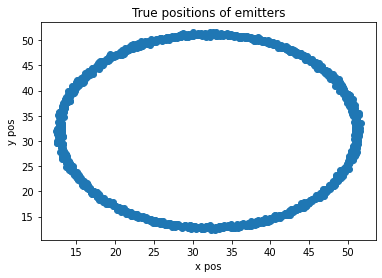

In [3]:
np.random.seed(0)
w = 64
N = 2000
numframes = 10
R = np.random.normal(0, 0.2, size=N) + w * 0.3
angle = np.random.uniform(0, 2 * math.pi, N)

xyzI = np.zeros((N,4))
xyzI[:,0] = R * np.cos(angle) + w / 2
xyzI[:,1] = R * np.sin(angle) + w / 2
xyzI[:,2] = np.linspace(-20,20,N)
xyzI[:,3] = 800

plt.figure()
plt.scatter(xyzI[:,0],xyzI[:,1])
plt.title('True positions of emitters')
plt.xlabel('x pos'); plt.ylabel('y pos');

## Generating the movie

Next, we simulate blinking of the emitters and generate ROI images from them, using the PSF object. The ROIs then get added into a full image.

This code assumes that the PSF object has 5 parameters in the order: x,y,z, intensity and background. 

Note that the roipos uses the same indexing as python, so the order is y,x instead of x,y for the PSF model parameters

Generating SMLM example movie
Applying poisson noise


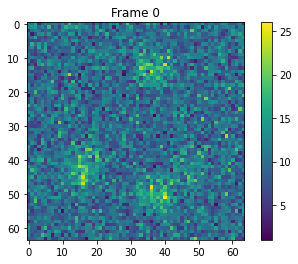

In [4]:
def generate_storm_movie(psf:Estimator, xyzI, numframes=100, 
                         imgsize=512, bg=5, p_on=0.1):
    
    frames = np.zeros((numframes, imgsize, imgsize), dtype=np.float32)

    for f in range(numframes):
        on = np.random.binomial(1, p_on, len(xyzI))

        roisize = psf.sampleshape[0]
        roipos = np.clip((xyzI[:,[1,0]] - roisize/2).astype(int), 0, imgsize-roisize)
        theta = np.zeros((len(xyzI),5)) # assuming xyzIb
        theta[:,0:4] = xyzI
        theta[:,[1,0]] -= roipos
        on_spots = np.nonzero(on)[0]

        rois = psf.ExpectedValue(theta[on_spots])
        
        frames[f] = ctx.smlm.DrawROIs((imgsize,imgsize), rois, roipos[on_spots])
        frames[f] += bg

    return frames

print("Generating SMLM example movie")
mov_expval = generate_storm_movie(psf, xyzI, numframes, 
                                      imgsize=w,bg=10, p_on=5 / N)
print("Applying poisson noise")
mov = np.random.poisson(mov_expval)

plt.figure()
plt.imshow(mov[0])
plt.title("Frame 0")
plt.colorbar();


## The PSF stack
The PSF stack is generated by evaluating the PSF at 3 Z positions. This is done using psf.ExpectedValue()


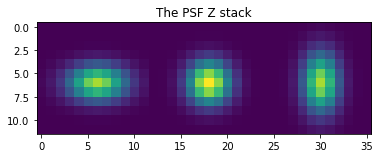

In [5]:
psfstack = psf_to_zstack(psf, np.linspace(-2,2,3))

plt.figure()
plt.imshow(np.concatenate(psfstack,-1))
plt.title('The PSF Z stack');

Passing debugMode=True to PSFConvSpotDetector() will make it send debugging images to the debug-image callback. 

max(convstackmax)=17.279329
sd frame 1. src hash 242959054. src-bg hash 242959054, f_img hash -306140286, convStackMaxFilter hash -340955568. Spot count: 4


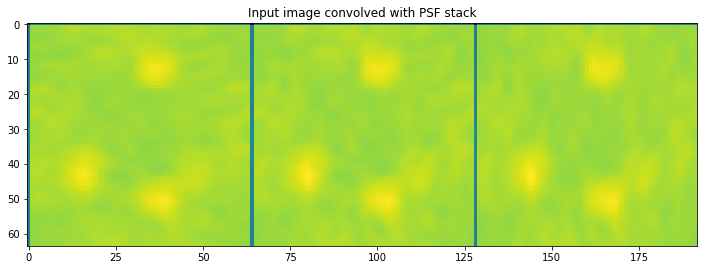

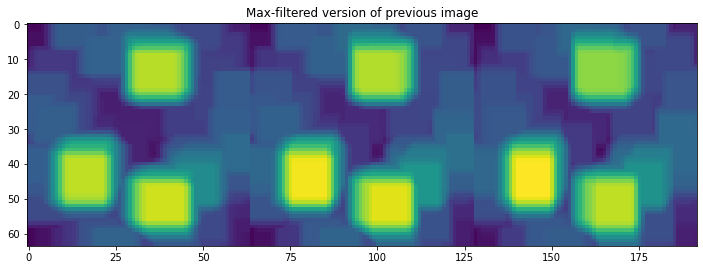

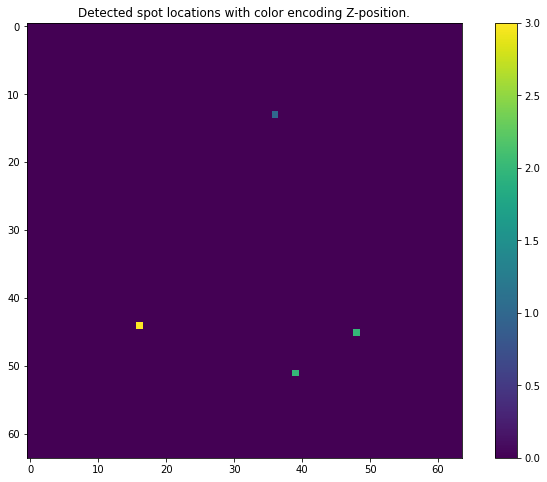

In [6]:
debugImageList = []
def addDebugImage(img,label):
    debugImageList.append(img)
ctx.smlm.SetDebugImageCallback(addDebugImage)

bgimg = mov[0]*0 # Spot detection background offset is just zeros
sd = PSFCorrelationSpotDetector(psfstack, bgimg, minPhotons=13, maxFilterSizeXY=10,debugMode=True)

rois,corners,scores,_=SpotDetectionMethods(ctx).ProcessFrame(mov[0], sd, roisize, maxSpotsPerFrame=200)

plt.figure(figsize=(12,8))
plt.imshow( np.concatenate(debugImageList[0],-1) )
plt.title('Input image convolved with PSF stack')

plt.figure(figsize=(12,8))
plt.imshow( np.concatenate(debugImageList[1],-1) )
plt.title('Max-filtered version of previous image')

plt.figure(figsize=(12,8))
plt.imshow( np.concatenate(debugImageList[2],-1) )
plt.title('Detected spot locations with color encoding Z-position.')
plt.colorbar();

## Result

Finally, we can show the extracted ROI of each spot:

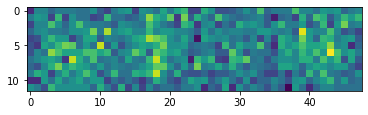

In [7]:
imshow_hstack(rois);

In [8]:
print(scores)

[16.459148 17.27933  13.611552 16.924234]
